# Sequential Neural Network
In this notebook I will train a Sequential Neural Network for detection of erosion.

In [1]:
# Adjust the frac parameter for loess smoothing
# to control the degree of smoothing applied to the scan data.
labeled_dir = "../../scandata/slices loess frac=0.20_labeled"

masks_path = "../stratified_k-fold_masks.npy"

DetectionNotClassification = True  # Set to True to replace all non-zero labels with 1

Libraries used:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)

from sklearn.preprocessing import StandardScaler

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Use GPU if available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)


2025-08-18 18:31:39.067753: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 18:31:39.077415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755541899.087725   61440 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755541899.090703   61440 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755541899.098798   61440 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Num GPUs Available: 1
TensorFlow version: 2.19.0


In [3]:
all_masks = np.load(masks_path, allow_pickle=True)

# List all labeled files
labeled_files = [f for f in os.listdir(labeled_dir) if f.endswith("_slices_labeled.npy")]
selected_files = labeled_files  # Use all files by default

In [4]:
# Load features (X) and labels (y) for each file
all_X = []
all_y = []
for labeled_file in selected_files:
    data = np.load(os.path.join(labeled_dir, labeled_file), allow_pickle=True).item()
    slices = data["slices"]  # shape: (num_slices, max_points, 3)
    labels = data["labels"]  # shape: (num_slices,)

    X = slices[:, :, 2]  # shape: (num_slices, max_points)
    if DetectionNotClassification:
        y = (labels != 0).astype(int)
    else:
        y = labels  # keep original labels for multiclass
    all_X.append(X)
    all_y.append(y)

I0000 00:00:1755541908.679548   61440 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/50


I0000 00:00:1755541910.295364   61673 service.cc:152] XLA service 0x75a100022430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755541910.295399   61673 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-18 18:31:50.341404: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755541910.487043   61673 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4688 - auc: 0.4688 - loss: 0.9886 - precision: 0.2812 - recall: 0.4500

I0000 00:00:1755541911.474471   61673 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 603ms/step - accuracy: 0.5813 - auc: 0.6457 - loss: 0.8723 - precision: 0.4372 - recall: 0.6875 - val_accuracy: 0.7414 - val_auc: 0.7548 - val_loss: 2.2980 - val_precision: 0.6500 - val_recall: 0.6190
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7661 - auc: 0.8932 - loss: 0.6682 - precision: 0.6168 - recall: 0.9055 - val_accuracy: 0.7586 - val_auc: 0.7986 - val_loss: 1.6465 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7772 - auc: 0.8836 - loss: 0.6524 - precision: 0.6409 - recall: 0.9303 - val_accuracy: 0.7586 - val_auc: 0.7928 - val_loss: 1.4099 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8193 - auc: 0.9265 - loss: 0.6072 - precision: 0.7151 - recall: 0.8585 - val_accuracy: 0.7586 - val_auc: 0.7915 - val_loss: 1.2877 - val_precision: 0.6842 - val_recall: 0.6190
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc

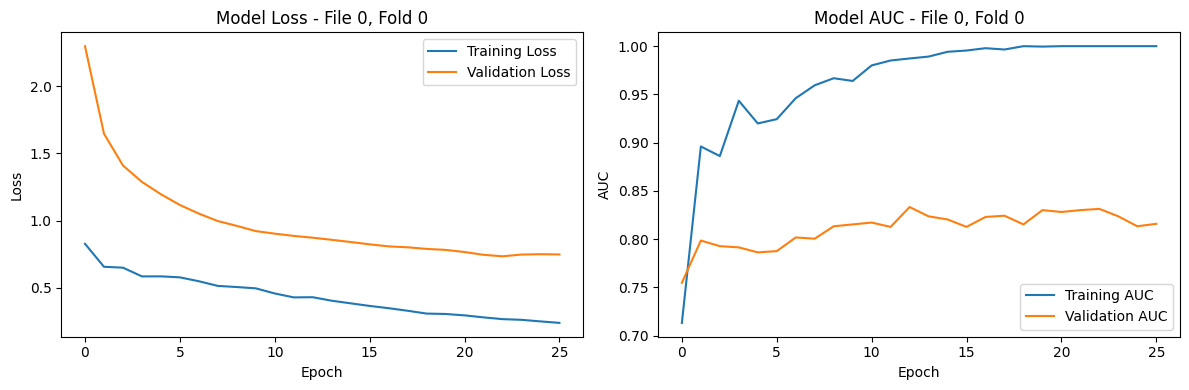

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step - accuracy: 0.7235 - auc: 0.7754 - loss: 0.7293 - precision: 0.5776 - recall: 0.6832 - val_accuracy: 0.6897 - val_auc: 0.8263 - val_loss: 1.8741 - val_precision: 0.5429 - val_recall: 0.9048
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8120 - auc: 0.9290 - loss: 0.5704 - precision: 0.6755 - recall: 0.8881 - val_accuracy: 0.7586 - val_auc: 0.8533 - val_loss: 1.2117 - val_precision: 0.6129 - val_recall: 0.9048
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8434 - auc: 0.9278 - loss: 0.5788 - precision: 0.7261 - recall: 0.8657 - val_accuracy: 0.7586 - val_auc: 0.8526 - val_loss: 1.0432 - val_precision: 0.6129 - val_recall: 0.9048
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8055 - auc: 0.9166 - loss: 0.5688 - precision: 0.7464 - recall: 0.7564 - val_accuracy: 0.7759 - val_auc: 0.8488 - val_loss: 0.9605 - val_precision: 0.6333 - val_recall: 0.9048
Epoc

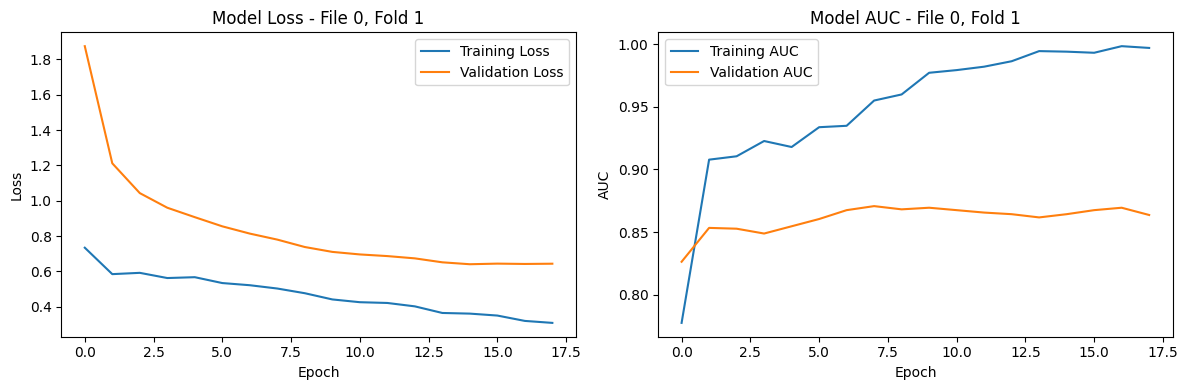

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 678ms/step - accuracy: 0.7043 - auc: 0.6885 - loss: 0.7850 - precision: 0.6211 - recall: 0.4269 - val_accuracy: 0.7414 - val_auc: 0.8050 - val_loss: 1.1035 - val_precision: 0.6364 - val_recall: 0.6667
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7727 - auc: 0.8870 - loss: 0.5873 - precision: 0.6580 - recall: 0.7688 - val_accuracy: 0.7414 - val_auc: 0.8597 - val_loss: 0.8500 - val_precision: 0.6500 - val_recall: 0.6190
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8111 - auc: 0.8842 - loss: 0.5989 - precision: 0.7123 - recall: 0.7870 - val_accuracy: 0.7414 - val_auc: 0.8668 - val_loss: 0.7873 - val_precision: 0.6667 - val_recall: 0.5714
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8354 - auc: 0.8984 - loss: 0.5918 - precision: 0.7867 - recall: 0.7751 - val_accuracy: 0.7241 - val_auc: 0.8507 - val_loss: 0.7605 - val_precision: 0.6471 - val_recall: 0.5238
Epoc

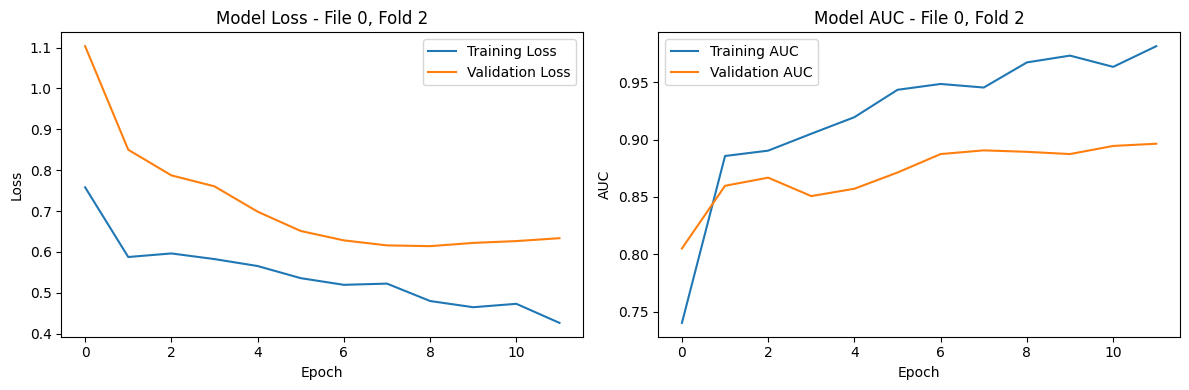

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x75a280c06ca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step - accuracy: 0.5373 - auc: 0.6696 - loss: 0.9672 - precision: 0.4322 - recall: 0.8427 - val_accuracy: 0.6552 - val_auc: 0.8816 - val_loss: 1.4899 - val_

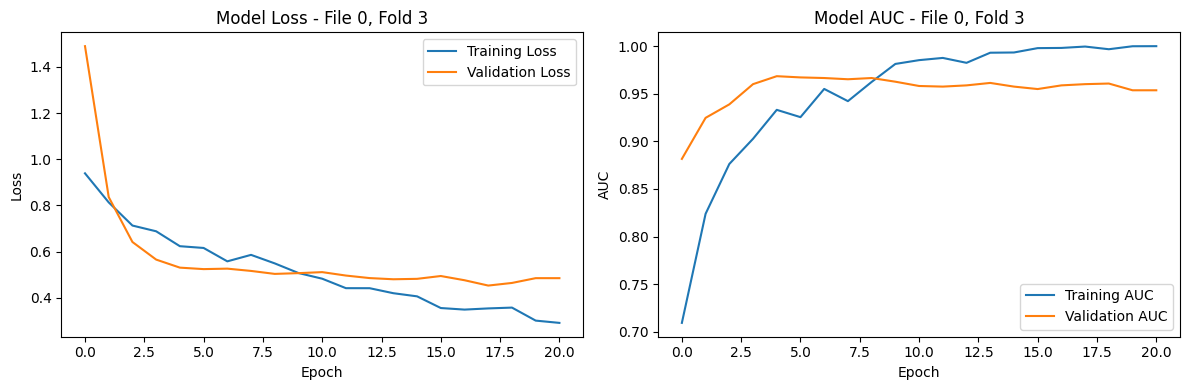

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 658ms/step - accuracy: 0.7021 - auc: 0.7199 - loss: 0.7580 - precision: 0.5536 - recall: 0.5685 - val_accuracy: 0.6724 - val_auc: 0.8031 - val_loss: 2.6674 - val_precision: 0.5278 - val_recall: 0.9048
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7874 - auc: 0.8956 - loss: 0.5921 - precision: 0.6560 - recall: 0.8648 - val_accuracy: 0.7241 - val_auc: 0.8616 - val_loss: 1.7398 - val_precision: 0.5758 - val_recall: 0.9048
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8321 - auc: 0.9214 - loss: 0.5733 - precision: 0.7008 - recall: 0.8606 - val_accuracy: 0.7586 - val_auc: 0.8842 - val_loss: 1.3060 - val_precision: 0.6129 - val_recall: 0.9048
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8484 - auc: 0.9303 - loss: 0.5513 - precision: 0.7872 - recall: 0.8191 - val_accuracy: 0.7586 - val_auc: 0.8880 - val_loss: 1.1225 - val_precision: 0.6129 - val_recall: 0.9048
Epoc

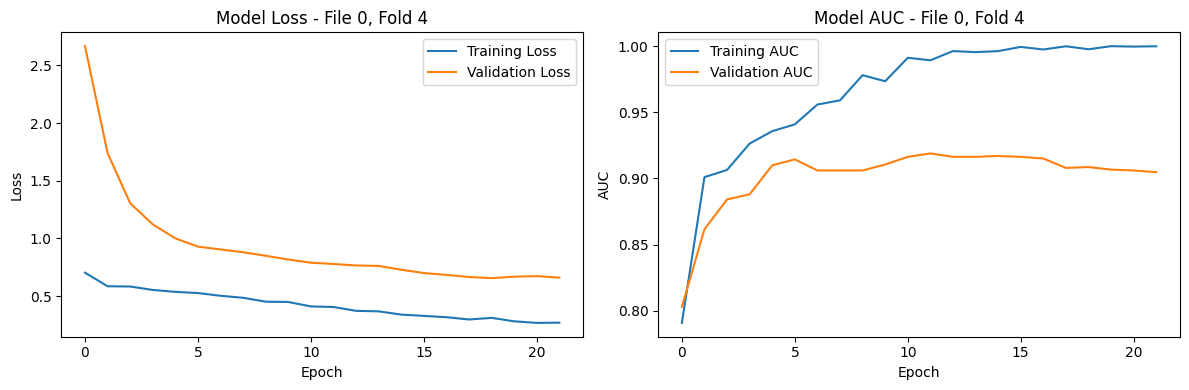

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 981ms/step - accuracy: 0.6215 - auc: 0.6016 - loss: 0.8505 - precision: 0.3708 - recall: 0.3818 - val_accuracy: 0.7273 - val_auc: 0.8449 - val_loss: 1.3661 - val_precision: 0.5263 - val_recall: 0.7692
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7889 - auc: 0.8472 - loss: 0.6241 - precision: 0.6981 - recall: 0.5994 - val_accuracy: 0.7727 - val_auc: 0.8784 - val_loss: 1.1171 - val_precision: 0.5882 - val_recall: 0.7692
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8025 - auc: 0.8672 - loss: 0.5890 - precision: 0.7271 - recall: 0.5943 - val_accuracy: 0.7727 - val_auc: 0.8784 - val_loss: 0.9252 - val_precision: 0.5882 - val_recall: 0.7692
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8628 - auc: 0.9091 - loss: 0.5604 - precision: 0.7638 - recall: 0.7658 - val_accuracy: 0.7727 - val_auc: 0.8797 - val_loss: 0.8641 - val_precision: 0.5882 - val_recall: 0.7692
Epoc

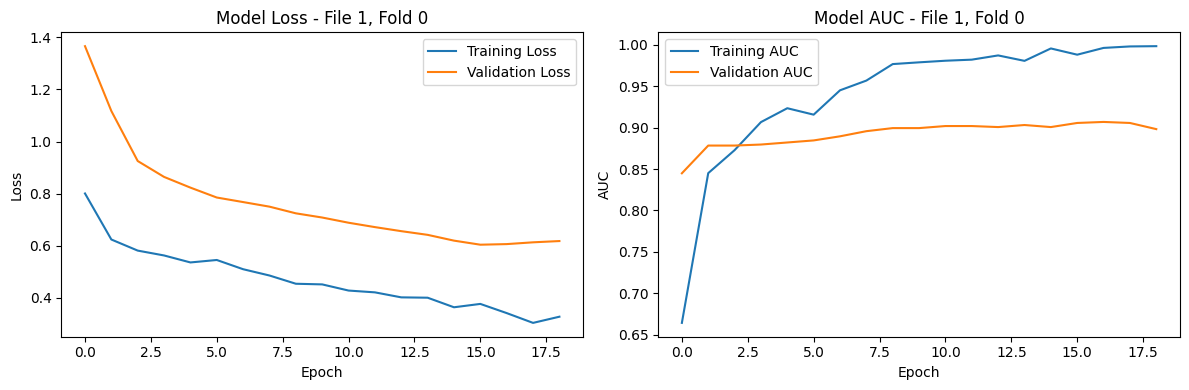

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 968ms/step - accuracy: 0.5884 - auc: 0.6204 - loss: 0.8860 - precision: 0.3976 - recall: 0.5471 - val_accuracy: 0.6744 - val_auc: 0.8185 - val_loss: 2.5239 - val_precision: 0.4583 - val_recall: 0.9167
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8158 - auc: 0.9193 - loss: 0.5920 - precision: 0.6926 - recall: 0.7910 - val_accuracy: 0.7209 - val_auc: 0.8266 - val_loss: 2.0903 - val_precision: 0.5000 - val_recall: 0.8333
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8516 - auc: 0.9102 - loss: 0.5955 - precision: 0.7030 - recall: 0.8544 - val_accuracy: 0.7442 - val_auc: 0.8226 - val_loss: 1.7037 - val_precision: 0.5263 - val_recall: 0.8333
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8681 - auc: 0.9498 - loss: 0.5328 - precision: 0.7702 - recall: 0.8448 - val_accuracy: 0.7209 - val_auc: 0.8374 - val_loss: 1.5343 - val_precision: 0.5000 - val_recall: 0.7500
Epoc

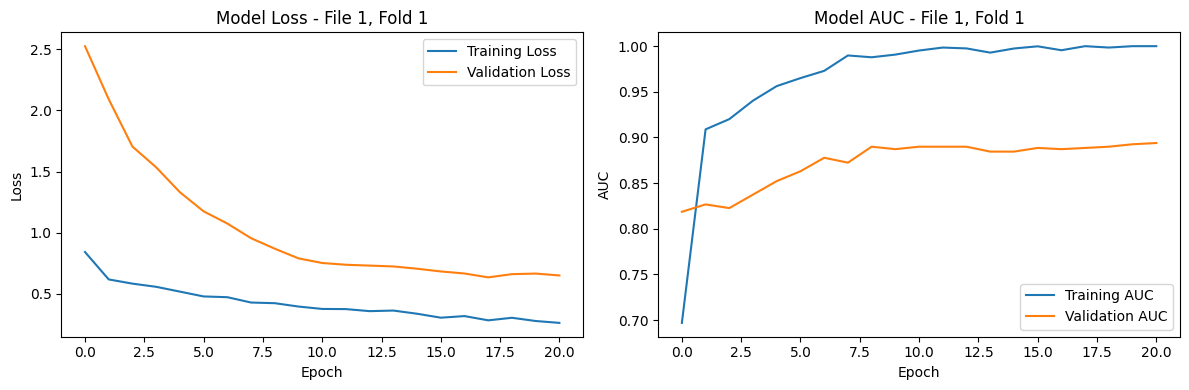

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 957ms/step - accuracy: 0.5246 - auc: 0.6350 - loss: 0.9576 - precision: 0.3607 - recall: 0.8159 - val_accuracy: 0.5581 - val_auc: 0.8744 - val_loss: 1.6241 - val_precision: 0.4062 - val_recall: 1.0000
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6839 - auc: 0.8548 - loss: 0.7770 - precision: 0.4791 - recall: 0.9435 - val_accuracy: 0.6512 - val_auc: 0.8821 - val_loss: 1.2731 - val_precision: 0.4643 - val_recall: 1.0000
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7274 - auc: 0.8778 - loss: 0.7352 - precision: 0.5291 - recall: 0.9140 - val_accuracy: 0.6977 - val_auc: 0.9013 - val_loss: 1.0680 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7643 - auc: 0.9070 - loss: 0.6910 - precision: 0.5614 - recall: 0.8914 - val_accuracy: 0.7442 - val_auc: 0.9115 - val_loss: 0.9236 - val_precision: 0.5417 - val_recall: 1.0000
Epoc

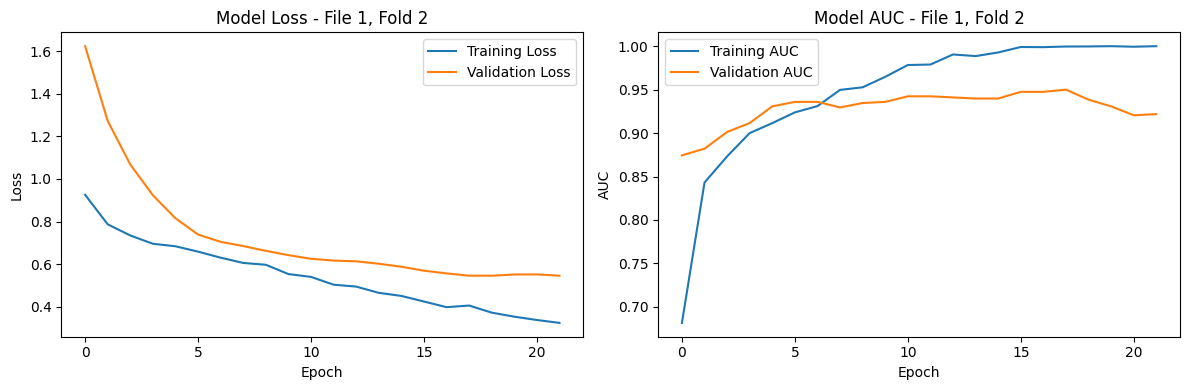

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 969ms/step - accuracy: 0.5496 - auc: 0.5388 - loss: 0.9516 - precision: 0.3303 - recall: 0.4066 - val_accuracy: 0.6744 - val_auc: 0.7205 - val_loss: 1.9313 - val_precision: 0.4706 - val_recall: 0.6154
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7555 - auc: 0.8722 - loss: 0.6622 - precision: 0.5599 - recall: 0.7788 - val_accuracy: 0.6512 - val_auc: 0.7500 - val_loss: 1.5309 - val_precision: 0.4545 - val_recall: 0.7692
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8196 - auc: 0.9230 - loss: 0.5733 - precision: 0.6465 - recall: 0.8265 - val_accuracy: 0.6279 - val_auc: 0.7641 - val_loss: 1.1656 - val_precision: 0.4348 - val_recall: 0.7692
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8749 - auc: 0.9411 - loss: 0.5401 - precision: 0.7472 - recall: 0.8600 - val_accuracy: 0.6512 - val_auc: 0.7923 - val_loss: 0.9979 - val_precision: 0.4545 - val_recall: 0.7692
Epoc

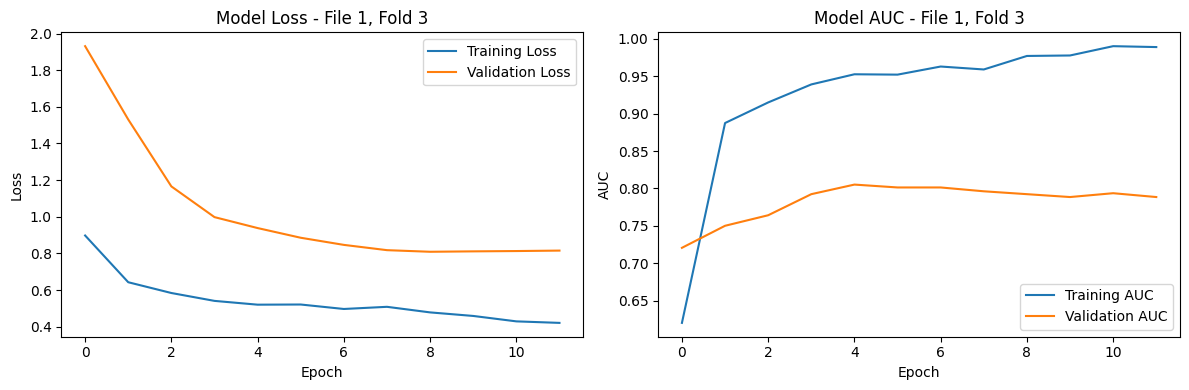

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 950ms/step - accuracy: 0.4207 - auc: 0.5580 - loss: 1.1021 - precision: 0.3177 - recall: 0.7934 - val_accuracy: 0.5581 - val_auc: 0.8308 - val_loss: 2.9669 - val_precision: 0.4062 - val_recall: 1.0000
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6840 - auc: 0.8747 - loss: 0.7853 - precision: 0.5033 - recall: 0.9576 - val_accuracy: 0.5581 - val_auc: 0.8487 - val_loss: 2.2219 - val_precision: 0.4000 - val_recall: 0.9231
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6439 - auc: 0.8788 - loss: 0.8290 - precision: 0.4143 - recall: 0.9630 - val_accuracy: 0.5349 - val_auc: 0.8577 - val_loss: 1.7638 - val_precision: 0.3871 - val_recall: 0.9231
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7206 - auc: 0.9004 - loss: 0.7729 - precision: 0.5100 - recall: 0.9676 - val_accuracy: 0.6047 - val_auc: 0.8718 - val_loss: 1.4828 - val_precision: 0.4286 - val_recall: 0.9231
Epoc

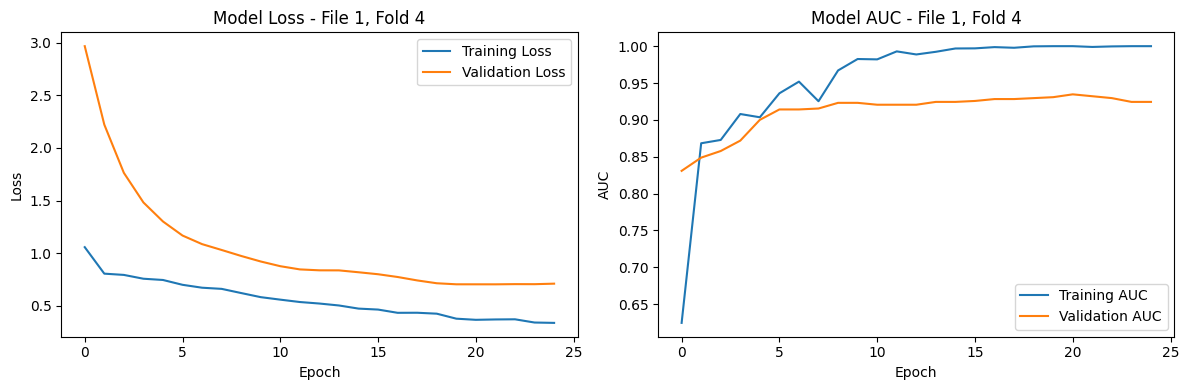

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6192 - auc: 0.6217 - loss: 0.8348 - precision: 0.4110 - recall: 0.5357 - val_accuracy: 0.5714 - val_auc: 0.6794 - val_loss: 4.0293 - val_precision: 0.4118 - val_recall: 0.9333
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8202 - auc: 0.9048 - loss: 0.5849 - precision: 0.6740 - recall: 0.8204 - val_accuracy: 0.5918 - val_auc: 0.7422 - val_loss: 2.7337 - val_precision: 0.4138 - val_recall: 0.8000
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8504 - auc: 0.9128 - loss: 0.5630 - precision: 0.7261 - recall: 0.8417 - val_accuracy: 0.5714 - val_auc: 0.7490 - val_loss: 2.2418 - val_precision: 0.3846 - val_recall: 0.6667
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8689 - auc: 0.9399 - loss: 0.5392 - precision: 0.7798 - recall: 0.8327 - val_accuracy: 0.6122 - val_auc: 0.7490 - val_loss: 1.9834 - val_precision: 0.4231 - val_recall: 0.7333
Epoch 5

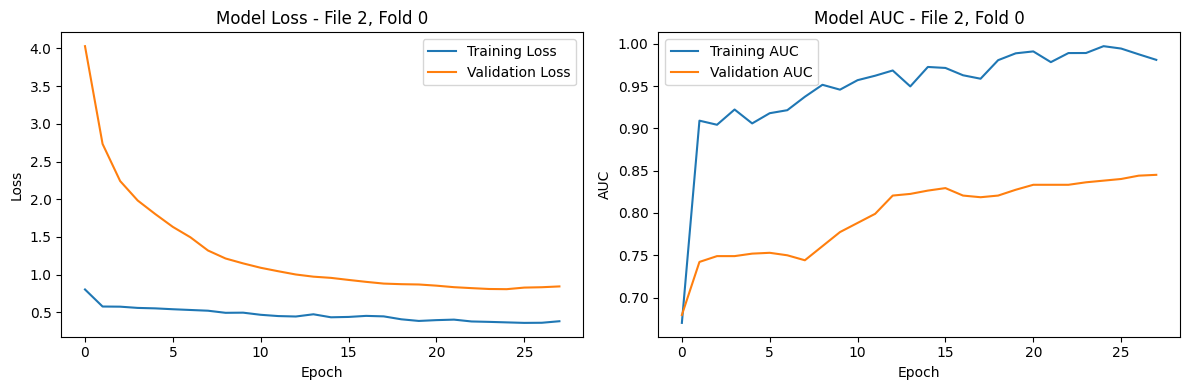

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step - accuracy: 0.5142 - auc: 0.6617 - loss: 0.9094 - precision: 0.3489 - recall: 0.7219 - val_accuracy: 0.7347 - val_auc: 0.8608 - val_loss: 1.4812 - val_precision: 0.5417 - val_recall: 0.8667
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7299 - auc: 0.8848 - loss: 0.7038 - precision: 0.5350 - recall: 0.9250 - val_accuracy: 0.8163 - val_auc: 0.8529 - val_loss: 1.1742 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7794 - auc: 0.8855 - loss: 0.6586 - precision: 0.5920 - recall: 0.8391 - val_accuracy: 0.8571 - val_auc: 0.8657 - val_loss: 0.9098 - val_precision: 0.7500 - val_recall: 0.8000
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8182 - auc: 0.9085 - loss: 0.5937 - precision: 0.6534 - recall: 0.8392 - val_accuracy: 0.8571 - val_auc: 0.8667 - val_loss: 0.8799 - val_precision: 0.7500 - val_recall: 0.8000
Epoc

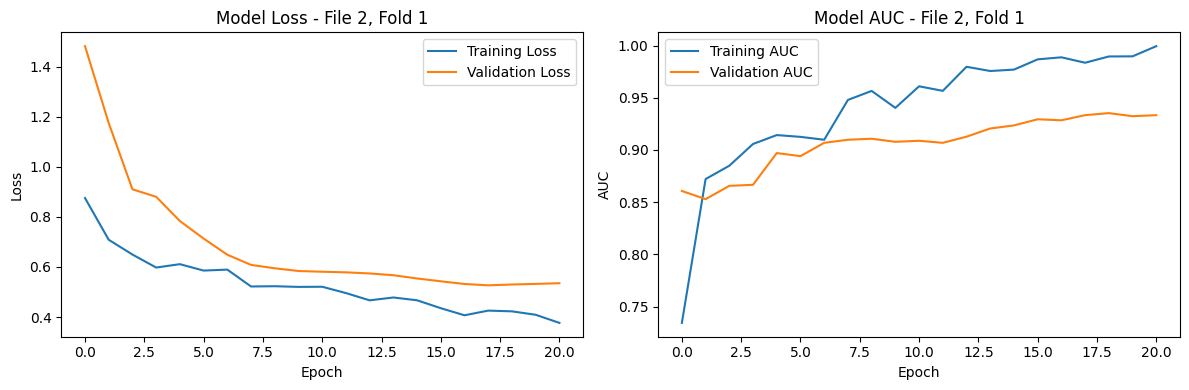

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 647ms/step - accuracy: 0.6116 - auc: 0.7100 - loss: 0.8824 - precision: 0.4375 - recall: 0.8074 - val_accuracy: 0.6939 - val_auc: 0.7814 - val_loss: 2.4671 - val_precision: 0.5000 - val_recall: 0.9333
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8291 - auc: 0.9271 - loss: 0.6064 - precision: 0.6622 - recall: 0.9034 - val_accuracy: 0.6531 - val_auc: 0.8157 - val_loss: 1.5559 - val_precision: 0.4545 - val_recall: 0.6667
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7928 - auc: 0.9070 - loss: 0.6081 - precision: 0.6296 - recall: 0.7935 - val_accuracy: 0.7143 - val_auc: 0.8382 - val_loss: 1.2507 - val_precision: 0.5263 - val_recall: 0.6667
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7674 - auc: 0.8856 - loss: 0.6879 - precision: 0.5607 - recall: 0.8177 - val_accuracy: 0.7347 - val_auc: 0.8392 - val_loss: 1.1124 - val_precision: 0.5556 - val_recall: 0.6667
Epoc

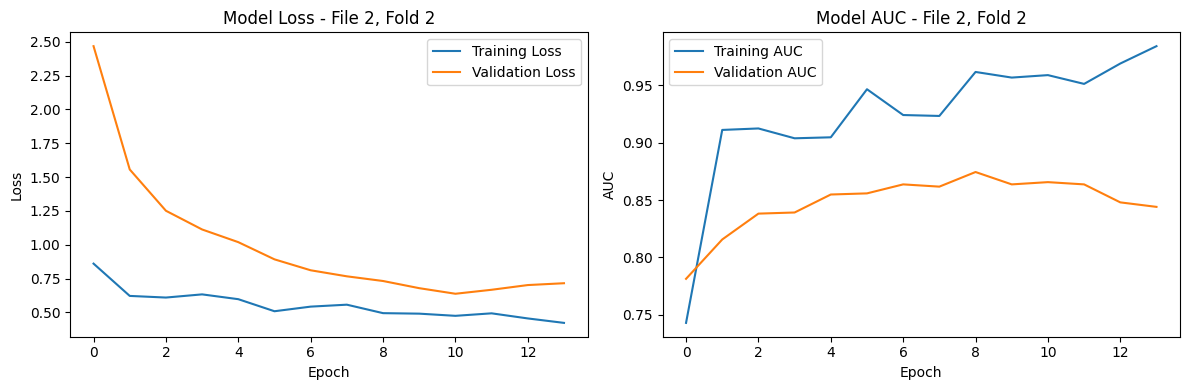

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 645ms/step - accuracy: 0.6129 - auc: 0.6582 - loss: 0.9333 - precision: 0.4052 - recall: 0.6630 - val_accuracy: 0.6122 - val_auc: 0.8382 - val_loss: 4.3910 - val_precision: 0.4412 - val_recall: 1.0000
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7375 - auc: 0.8396 - loss: 0.7367 - precision: 0.5497 - recall: 0.8237 - val_accuracy: 0.6122 - val_auc: 0.8990 - val_loss: 2.9568 - val_precision: 0.4412 - val_recall: 1.0000
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7943 - auc: 0.8859 - loss: 0.6271 - precision: 0.6358 - recall: 0.8175 - val_accuracy: 0.6122 - val_auc: 0.9069 - val_loss: 2.2131 - val_precision: 0.4412 - val_recall: 1.0000
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8430 - auc: 0.8949 - loss: 0.5981 - precision: 0.7075 - recall: 0.8434 - val_accuracy: 0.6531 - val_auc: 0.9000 - val_loss: 1.8063 - val_precision: 0.4688 - val_recall: 1.0000
Epoc

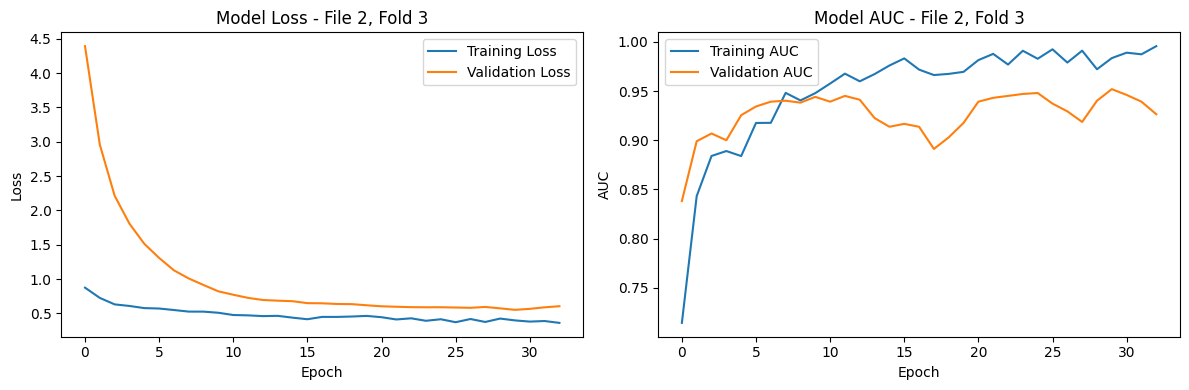

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 647ms/step - accuracy: 0.4893 - auc: 0.5872 - loss: 0.9901 - precision: 0.3204 - recall: 0.6319 - val_accuracy: 0.6531 - val_auc: 0.7706 - val_loss: 1.8582 - val_precision: 0.4615 - val_recall: 0.8000
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6832 - auc: 0.8865 - loss: 0.7280 - precision: 0.4600 - recall: 0.8674 - val_accuracy: 0.7143 - val_auc: 0.8696 - val_loss: 1.2262 - val_precision: 0.5200 - val_recall: 0.8667
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7502 - auc: 0.8819 - loss: 0.6670 - precision: 0.5847 - recall: 0.8743 - val_accuracy: 0.7347 - val_auc: 0.8922 - val_loss: 0.9059 - val_precision: 0.5417 - val_recall: 0.8667
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7919 - auc: 0.9220 - loss: 0.6106 - precision: 0.6122 - recall: 0.9051 - val_accuracy: 0.7551 - val_auc: 0.8951 - val_loss: 0.7914 - val_precision: 0.5652 - val_recall: 0.8667
Epoc

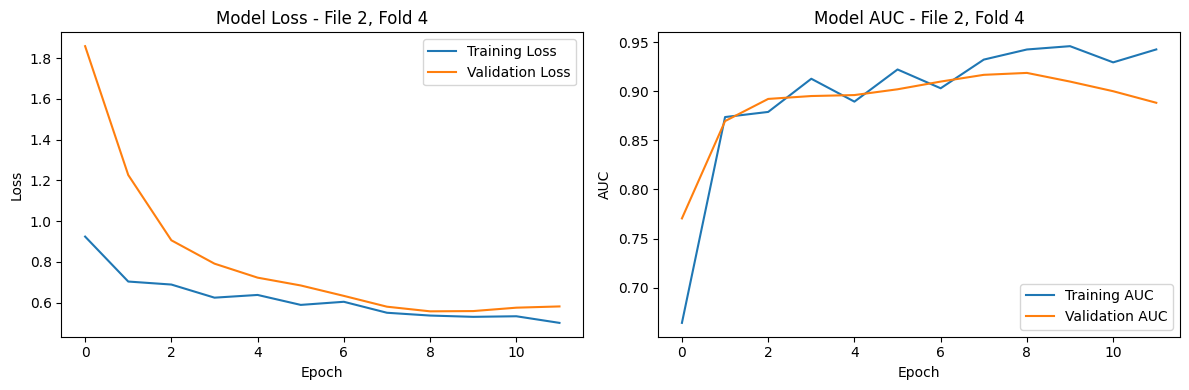

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 753ms/step - accuracy: 0.3958 - auc: 0.6657 - loss: 1.0723 - precision: 0.2595 - recall: 0.7990 - val_accuracy: 0.6269 - val_auc: 0.8141 - val_loss: 1.7024 - val_precision: 0.3947 - val_recall: 0.8824
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5425 - auc: 0.8659 - loss: 0.8356 - precision: 0.3643 - recall: 0.9742 - val_accuracy: 0.5970 - val_auc: 0.8376 - val_loss: 1.3602 - val_precision: 0.3750 - val_recall: 0.8824
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6387 - auc: 0.8864 - loss: 0.7645 - precision: 0.4220 - recall: 0.9313 - val_accuracy: 0.6269 - val_auc: 0.8671 - val_loss: 1.1414 - val_precision: 0.3947 - val_recall: 0.8824
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6993 - auc: 0.9270 - loss: 0.7226 - precision: 0.4468 - recall: 0.9556 - val_accuracy: 0.6269 - val_auc: 0.8918 - val_loss: 0.9343 - val_precision: 0.3947 - val_recall: 0.8824
Epoc

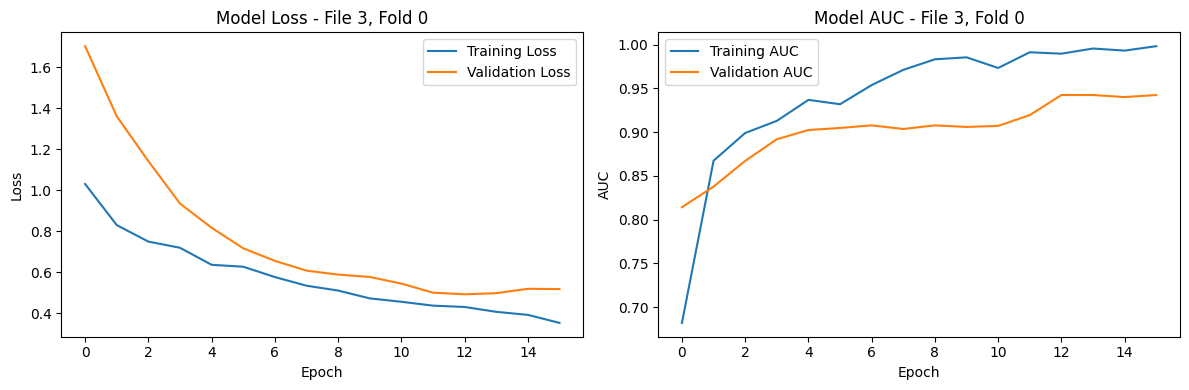

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step - accuracy: 0.5329 - auc: 0.6706 - loss: 0.9089 - precision: 0.3198 - recall: 0.7288 - val_accuracy: 0.6716 - val_auc: 0.7947 - val_loss: 1.3415 - val_precision: 0.4194 - val_recall: 0.7647
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7050 - auc: 0.8783 - loss: 0.7165 - precision: 0.4381 - recall: 0.9007 - val_accuracy: 0.8060 - val_auc: 0.8447 - val_loss: 0.8468 - val_precision: 0.5909 - val_recall: 0.7647
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8101 - auc: 0.9226 - loss: 0.5891 - precision: 0.5947 - recall: 0.8961 - val_accuracy: 0.8358 - val_auc: 0.8718 - val_loss: 0.6135 - val_precision: 0.6500 - val_recall: 0.7647
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7882 - auc: 0.9140 - loss: 0.5898 - precision: 0.5452 - recall: 0.8764 - val_accuracy: 0.8507 - val_auc: 0.8818 - val_loss: 0.5380 - val_precision: 0.7059 - val_recall: 0.7059
Epoc

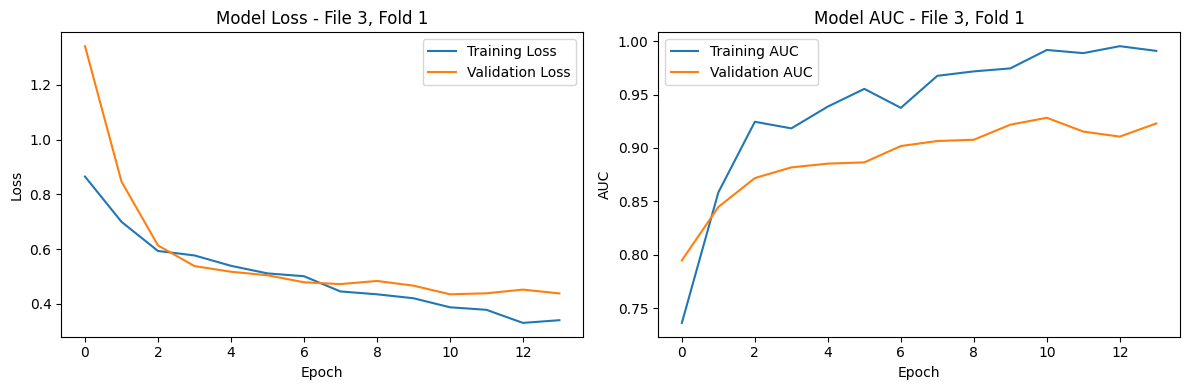

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 580ms/step - accuracy: 0.5550 - auc: 0.6399 - loss: 0.9390 - precision: 0.3397 - recall: 0.7558 - val_accuracy: 0.7761 - val_auc: 0.9478 - val_loss: 0.7616 - val_precision: 0.5517 - val_recall: 0.8889
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7441 - auc: 0.9030 - loss: 0.6488 - precision: 0.5094 - recall: 0.9234 - val_accuracy: 0.8358 - val_auc: 0.9541 - val_loss: 0.5723 - val_precision: 0.6400 - val_recall: 0.8889
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8118 - auc: 0.9079 - loss: 0.6194 - precision: 0.5719 - recall: 0.8944 - val_accuracy: 0.8806 - val_auc: 0.9586 - val_loss: 0.4020 - val_precision: 0.7273 - val_recall: 0.8889
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8168 - auc: 0.9163 - loss: 0.5564 - precision: 0.6177 - recall: 0.8568 - val_accuracy: 0.9403 - val_auc: 0.9666 - val_loss: 0.3445 - val_precision: 0.8889 - val_recall: 0.8889
Epoc

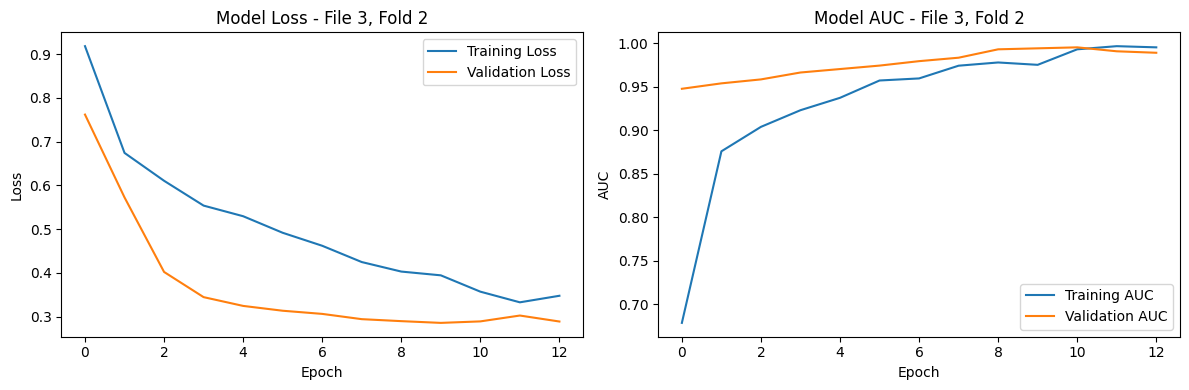

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 572ms/step - accuracy: 0.5745 - auc: 0.7010 - loss: 1.0132 - precision: 0.3578 - recall: 0.7949 - val_accuracy: 0.7164 - val_auc: 0.7800 - val_loss: 3.2348 - val_precision: 0.4800 - val_recall: 0.6667
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6665 - auc: 0.8815 - loss: 0.7739 - precision: 0.4155 - recall: 0.8829 - val_accuracy: 0.7463 - val_auc: 0.7795 - val_loss: 1.9899 - val_precision: 0.5217 - val_recall: 0.6667
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7118 - auc: 0.8798 - loss: 0.7498 - precision: 0.4476 - recall: 0.8720 - val_accuracy: 0.7463 - val_auc: 0.7931 - val_loss: 1.4329 - val_precision: 0.5217 - val_recall: 0.6667
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7575 - auc: 0.9119 - loss: 0.6549 - precision: 0.5120 - recall: 0.8723 - val_accuracy: 0.7313 - val_auc: 0.8039 - val_loss: 1.1746 - val_precision: 0.5000 - val_recall: 0.6667
Epoc

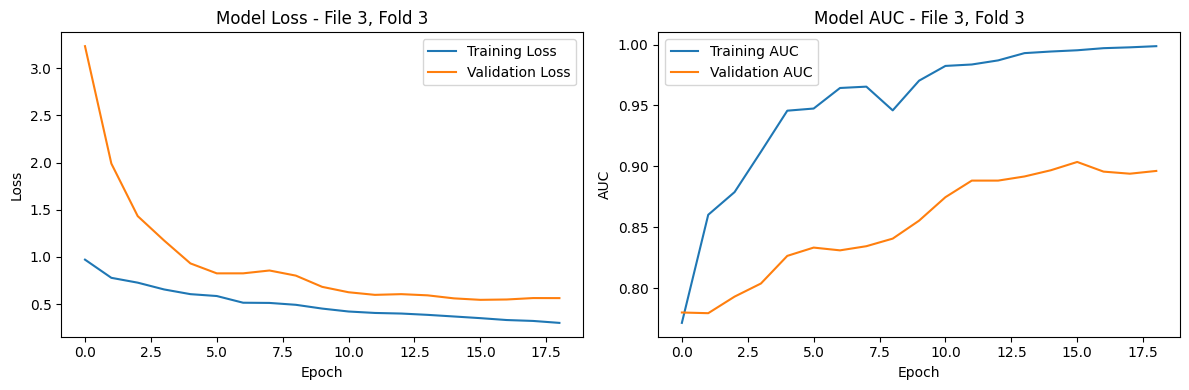

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 685ms/step - accuracy: 0.6594 - auc: 0.6526 - loss: 0.8225 - precision: 0.4036 - recall: 0.5938 - val_accuracy: 0.7576 - val_auc: 0.8511 - val_loss: 1.1534 - val_precision: 0.5185 - val_recall: 0.8235
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7726 - auc: 0.8654 - loss: 0.6063 - precision: 0.5467 - recall: 0.7189 - val_accuracy: 0.7727 - val_auc: 0.8752 - val_loss: 0.7442 - val_precision: 0.5417 - val_recall: 0.7647
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7905 - auc: 0.9024 - loss: 0.5655 - precision: 0.5707 - recall: 0.7944 - val_accuracy: 0.8636 - val_auc: 0.8758 - val_loss: 0.5900 - val_precision: 0.7222 - val_recall: 0.7647
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8554 - auc: 0.9428 - loss: 0.5186 - precision: 0.6710 - recall: 0.7946 - val_accuracy: 0.8636 - val_auc: 0.8962 - val_loss: 0.5431 - val_precision: 0.7500 - val_recall: 0.7059
Epoc

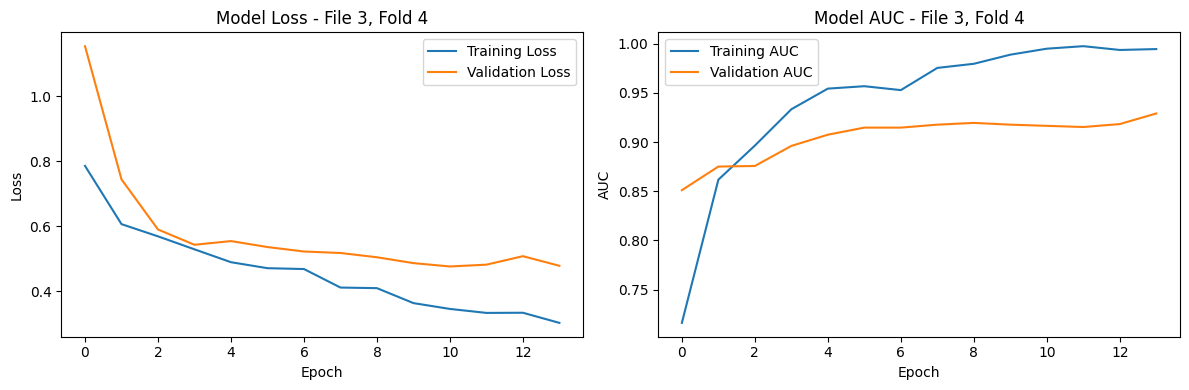

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 715ms/step - accuracy: 0.6278 - auc: 0.6821 - loss: 0.8852 - precision: 0.4188 - recall: 0.6605 - val_accuracy: 0.8060 - val_auc: 0.8452 - val_loss: 1.8992 - val_precision: 0.6207 - val_recall: 0.9000
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7652 - auc: 0.8725 - loss: 0.6680 - precision: 0.5802 - recall: 0.8220 - val_accuracy: 0.8060 - val_auc: 0.8729 - val_loss: 1.1830 - val_precision: 0.6207 - val_recall: 0.9000
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8542 - auc: 0.9278 - loss: 0.5695 - precision: 0.7214 - recall: 0.8207 - val_accuracy: 0.8209 - val_auc: 0.8920 - val_loss: 0.9613 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8410 - auc: 0.9119 - loss: 0.5819 - precision: 0.6794 - recall: 0.8220 - val_accuracy: 0.8209 - val_auc: 0.8979 - val_loss: 0.8133 - val_precision: 0.6429 - val_recall: 0.9000
Epoch

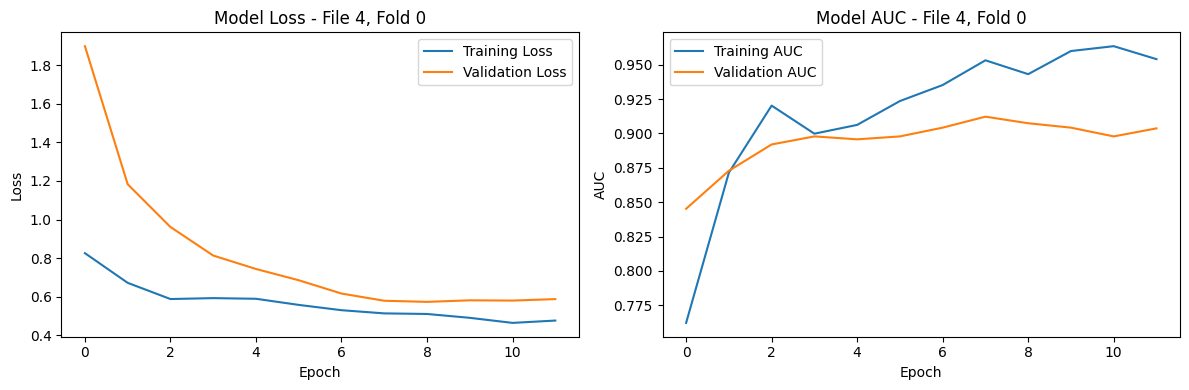

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step - accuracy: 0.5949 - auc: 0.6362 - loss: 0.9964 - precision: 0.3749 - recall: 0.7051 - val_accuracy: 0.7727 - val_auc: 0.7917 - val_loss: 1.9729 - val_precision: 0.5769 - val_recall: 0.7895
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7547 - auc: 0.8731 - loss: 0.6983 - precision: 0.5623 - recall: 0.8276 - val_accuracy: 0.7727 - val_auc: 0.8242 - val_loss: 1.3375 - val_precision: 0.5833 - val_recall: 0.7368
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8401 - auc: 0.8971 - loss: 0.6638 - precision: 0.6680 - recall: 0.9042 - val_accuracy: 0.7727 - val_auc: 0.8343 - val_loss: 1.0741 - val_precision: 0.5833 - val_recall: 0.7368
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8029 - auc: 0.8883 - loss: 0.6621 - precision: 0.6286 - recall: 0.8529 - val_accuracy: 0.7879 - val_auc: 0.8595 - val_loss: 0.8859 - val_precision: 0.6087 - val_recall: 0.7368
Epoc

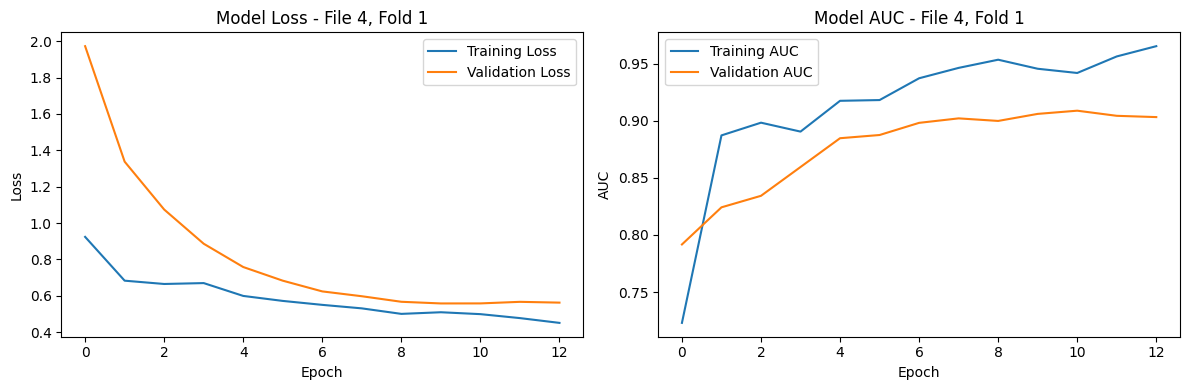

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 585ms/step - accuracy: 0.6778 - auc: 0.7162 - loss: 0.7319 - precision: 0.4191 - recall: 0.4683 - val_accuracy: 0.6364 - val_auc: 0.7525 - val_loss: 2.3780 - val_precision: 0.4194 - val_recall: 0.6842
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7931 - auc: 0.8473 - loss: 0.6151 - precision: 0.6626 - recall: 0.6349 - val_accuracy: 0.7273 - val_auc: 0.8320 - val_loss: 1.1990 - val_precision: 0.5185 - val_recall: 0.7368
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7912 - auc: 0.8729 - loss: 0.5867 - precision: 0.6318 - recall: 0.6591 - val_accuracy: 0.7879 - val_auc: 0.8550 - val_loss: 0.9163 - val_precision: 0.6087 - val_recall: 0.7368
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8518 - auc: 0.9199 - loss: 0.5216 - precision: 0.7374 - recall: 0.7418 - val_accuracy: 0.8030 - val_auc: 0.8785 - val_loss: 0.7673 - val_precision: 0.6364 - val_recall: 0.7368
Epoc

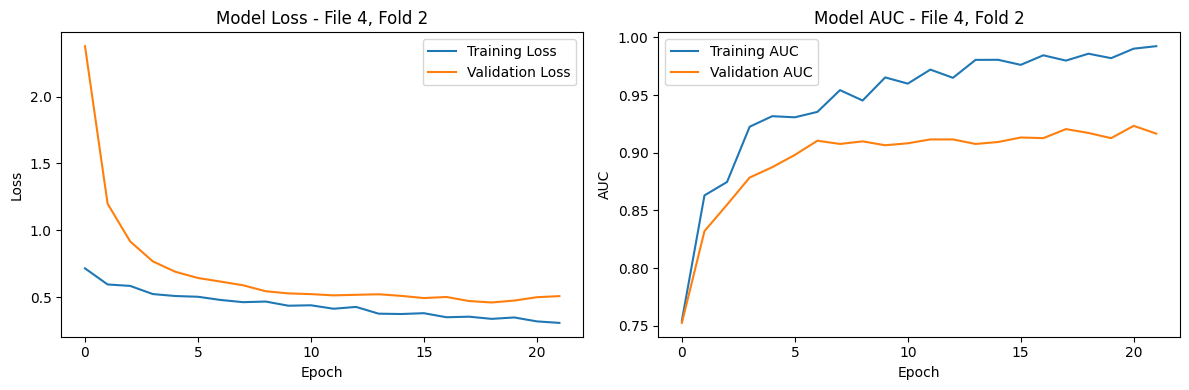

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 583ms/step - accuracy: 0.6706 - auc: 0.7153 - loss: 0.7669 - precision: 0.4404 - recall: 0.5676 - val_accuracy: 0.7424 - val_auc: 0.8679 - val_loss: 1.2829 - val_precision: 0.5357 - val_recall: 0.7895
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7669 - auc: 0.8536 - loss: 0.6839 - precision: 0.5781 - recall: 0.7961 - val_accuracy: 0.8030 - val_auc: 0.9003 - val_loss: 0.8104 - val_precision: 0.6250 - val_recall: 0.7895
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8109 - auc: 0.9050 - loss: 0.5784 - precision: 0.6497 - recall: 0.7535 - val_accuracy: 0.8182 - val_auc: 0.9054 - val_loss: 0.7870 - val_precision: 0.6522 - val_recall: 0.7895
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8260 - auc: 0.9123 - loss: 0.5650 - precision: 0.6541 - recall: 0.8099 - val_accuracy: 0.7879 - val_auc: 0.9087 - val_loss: 0.8584 - val_precision: 0.5926 - val_recall: 0.8421
Epoc

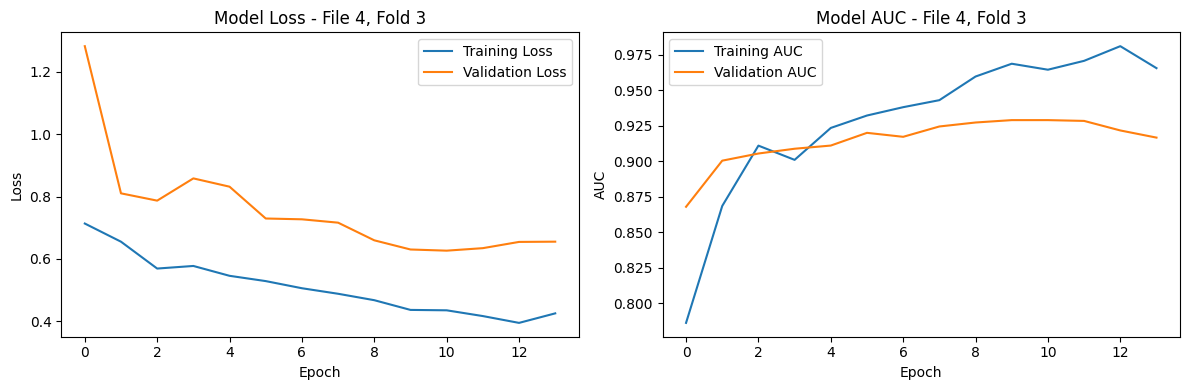

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 576ms/step - accuracy: 0.5386 - auc: 0.6441 - loss: 0.9415 - precision: 0.3614 - recall: 0.6527 - val_accuracy: 0.7727 - val_auc: 0.9183 - val_loss: 1.7500 - val_precision: 0.5625 - val_recall: 0.9474
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7479 - auc: 0.8494 - loss: 0.7307 - precision: 0.5376 - recall: 0.8252 - val_accuracy: 0.8182 - val_auc: 0.9132 - val_loss: 1.0824 - val_precision: 0.6129 - val_recall: 1.0000
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7838 - auc: 0.8747 - loss: 0.7368 - precision: 0.5792 - recall: 0.8516 - val_accuracy: 0.8182 - val_auc: 0.9323 - val_loss: 0.8289 - val_precision: 0.6207 - val_recall: 0.9474
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8539 - auc: 0.9027 - loss: 0.6566 - precision: 0.6955 - recall: 0.9207 - val_accuracy: 0.8636 - val_auc: 0.9429 - val_loss: 0.7088 - val_precision: 0.6923 - val_recall: 0.9474
Epoc

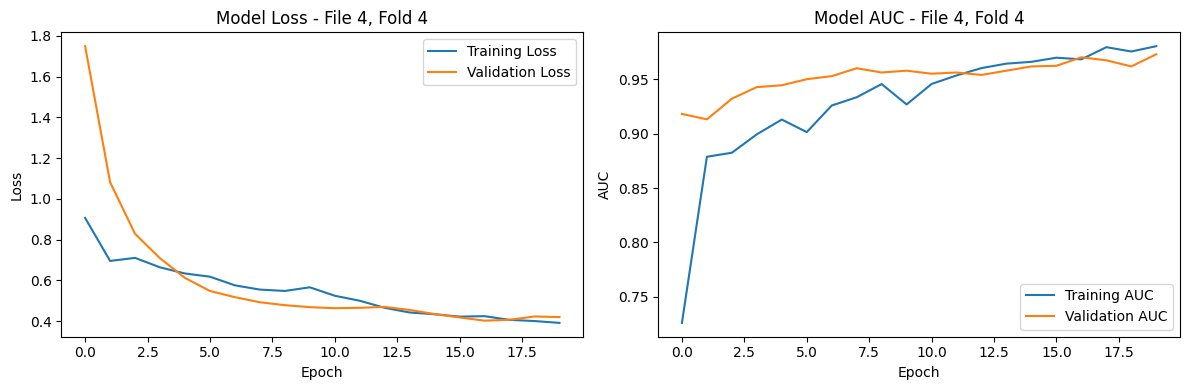

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [5]:
# Cross-validation using stratified k-Fold masks
n_folds = len(all_masks[0])
results = []

for file_idx, (X, y, masks) in enumerate(zip(all_X, all_y, all_masks)):
    file_results = []
    n_classes = len(np.unique(y))
    for fold_idx, val_mask in enumerate(masks):
        train_mask = ~val_mask
        X_train, y_train = X[train_mask], y[train_mask]
        X_val, y_val = X[val_mask], y[val_mask]

        # Scale using only the training data to prevent data leakage
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # One-hot encode labels for keras if multiclass
        if len(np.unique(y_train)) > 2:
            # Create mapping from original labels to consecutive indices
            unique_labels = sorted(np.unique(y_train))
            label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
            idx_to_label = {idx: label for label, idx in label_to_idx.items()}
            
            # Map labels to consecutive indices
            y_train_mapped = np.array([label_to_idx[label] for label in y_train])
            y_val_mapped = np.array([label_to_idx[label] for label in y_val])
            
            n_classes = len(unique_labels)
            y_train_cat = keras.utils.to_categorical(y_train_mapped, num_classes=n_classes)
            y_val_cat = keras.utils.to_categorical(y_val_mapped, num_classes=n_classes)
            loss_fn = "categorical_crossentropy"
            activation = "softmax"
        else:
            y_train_cat = y_train
            y_val_cat = y_val
            n_classes = 2
            loss_fn = "binary_crossentropy"
            activation = "sigmoid"

        # Build model
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        model.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(negative_slope=0.01))
        model.add(layers.Dropout(0.3)) 
        model.add(layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(negative_slope=0.01))
        model.add(layers.Dropout(0.3))  
        model.add(layers.Dense(n_classes if n_classes > 2 else 1, activation=activation))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss=loss_fn,
            metrics=["accuracy", "precision", "recall", AUC(name='auc')]
        )

        # Train model with Early Stopping and Learning Rate Scheduling; store history
        history = model.fit(
            X_train_scaled, y_train_cat,
            epochs=50,
            batch_size=64,
            verbose=1,
            validation_data=(X_val_scaled, y_val_cat),
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
              # ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
            ]
        )

        # Plot learning curves for this fold
        plt.figure(figsize=(12, 4))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss - File {file_idx}, Fold {fold_idx}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot AUC
        plt.subplot(1, 2, 2)
        plt.plot(history.history['auc'], label='Training AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.title(f'Model AUC - File {file_idx}, Fold {fold_idx}')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        # Predict
        if n_classes > 2:
            y_pred_proba = model.predict(X_val_scaled)
            y_pred_idx = np.argmax(y_pred_proba, axis=1)
            # Map back to original labels
            y_pred_class = np.array([idx_to_label[idx] for idx in y_pred_idx])
        else:
            y_pred_proba = model.predict(X_val_scaled).flatten()
            y_pred_class = (y_pred_proba > 0.5).astype(int)

        # Metrics
        avg = 'weighted'
        try:
            if n_classes > 2:
                roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovr', average='weighted')
            else:
                roc_auc = roc_auc_score(y_val, y_pred_proba)
        except Exception:
            roc_auc = np.nan

        metrics = {
            "accuracy": accuracy_score(y_val, y_pred_class),
            "precision": precision_score(y_val, y_pred_class, average=avg, zero_division=0),
            "recall": recall_score(y_val, y_pred_class, average=avg, zero_division=0),
            "f1": f1_score(y_val, y_pred_class, average=avg, zero_division=0),
            "roc_auc": roc_auc,
            "confusion_matrix": confusion_matrix(y_val, y_pred_class, labels=sorted(np.unique(y))).tolist(),
            "fold": fold_idx,
            "file": selected_files[file_idx],
        }
        file_results.append(metrics)
    results.extend(file_results)

                                                    accuracy  precision  \
file                                                                      
221111_144114__binary_onlylines114378to117271 l...  0.817241   0.823419   
221111_144114__binary_onlylines145900to148050 l...  0.791543   0.828134   
221111_144114__binary_onlylines25660to28100 loe...  0.816327   0.829643   
221111_144114__binary_onlylines47178to50517 loe...  0.865265   0.869172   
221111_144114__binary_onlylines86841to90142 loe...  0.837042   0.847348   

                                                      recall        f1  \
file                                                                     
221111_144114__binary_onlylines114378to117271 l...  0.817241  0.816396   
221111_144114__binary_onlylines145900to148050 l...  0.791543  0.799242   
221111_144114__binary_onlylines25660to28100 loe...  0.816327  0.819058   
221111_144114__binary_onlylines47178to50517 loe...  0.865265  0.865321   
221111_144114__binary_onlyline

/tmp/ipykernel_61440/1605691262.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


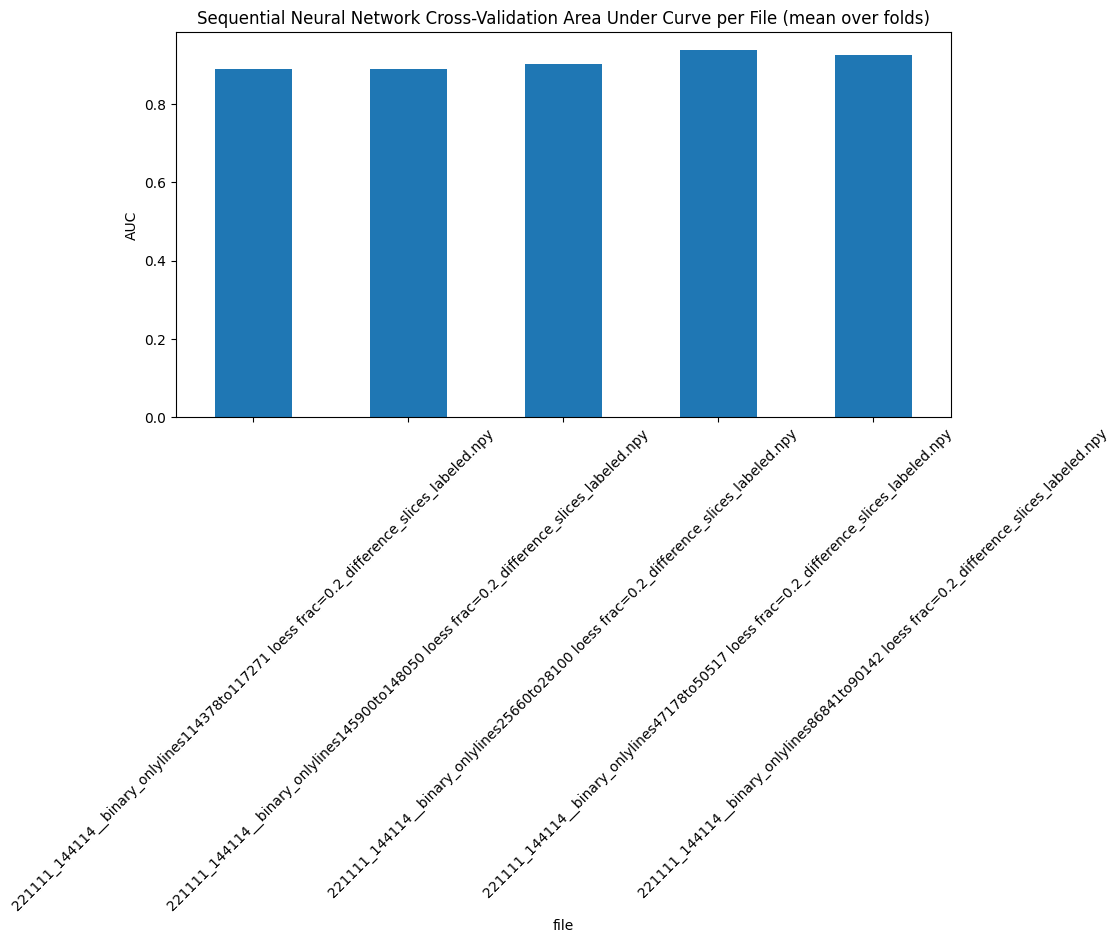

In [6]:
# Summarize results
df = pd.DataFrame(results)
print(df.groupby("file")[["accuracy", "precision", "recall", "f1", "roc_auc"]].mean())

# Optional: plot AUC per file
df.groupby("file")["roc_auc"].mean().plot.bar(rot=45, figsize=(10, 5))
plt.title("Sequential Neural Network Cross-Validation Area Under Curve per File (mean over folds)")
plt.ylabel("AUC")
plt.tight_layout()
plt.show()

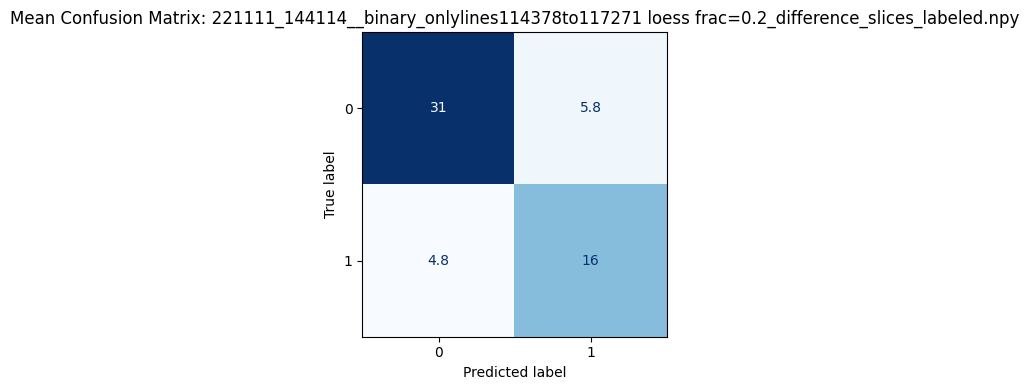

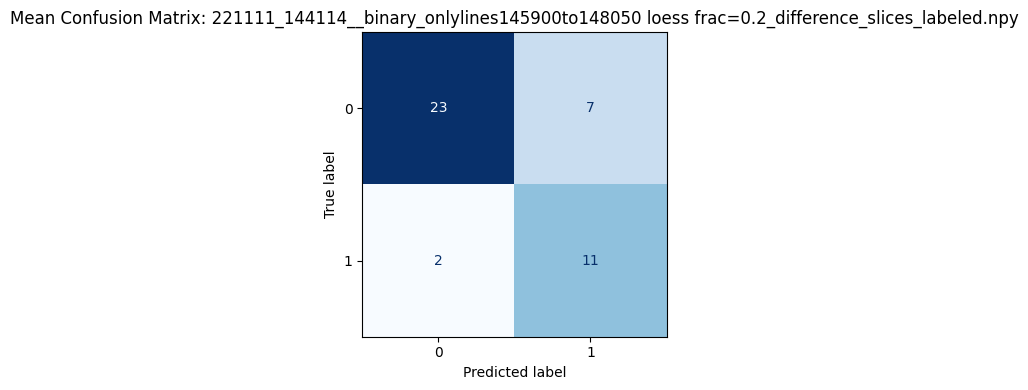

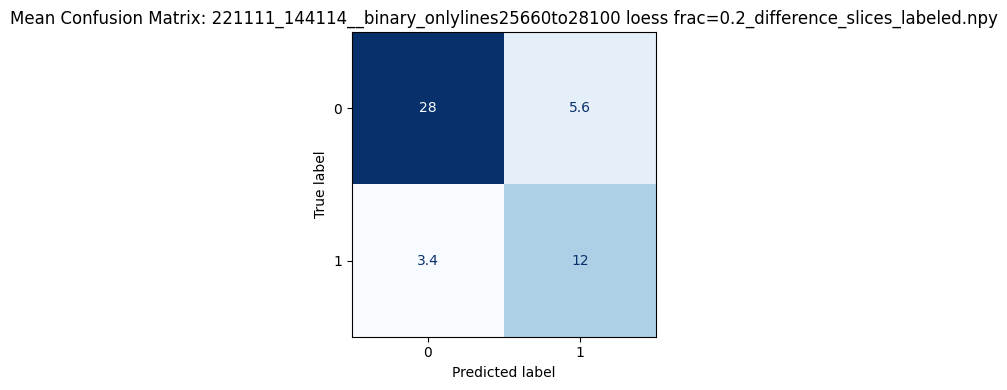

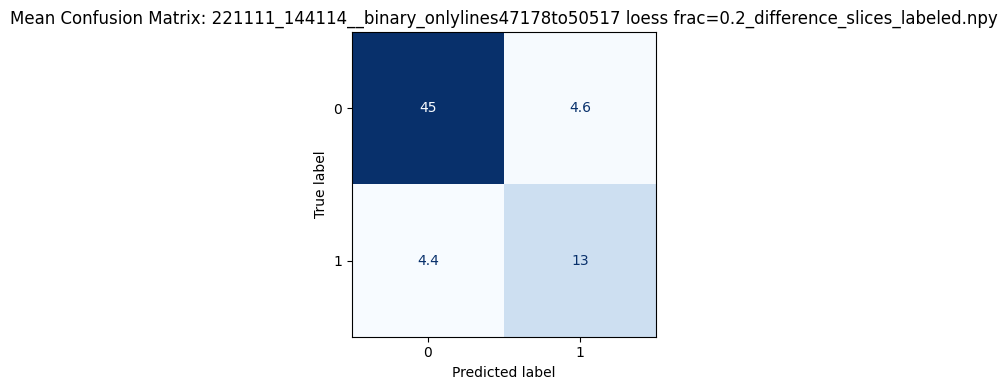

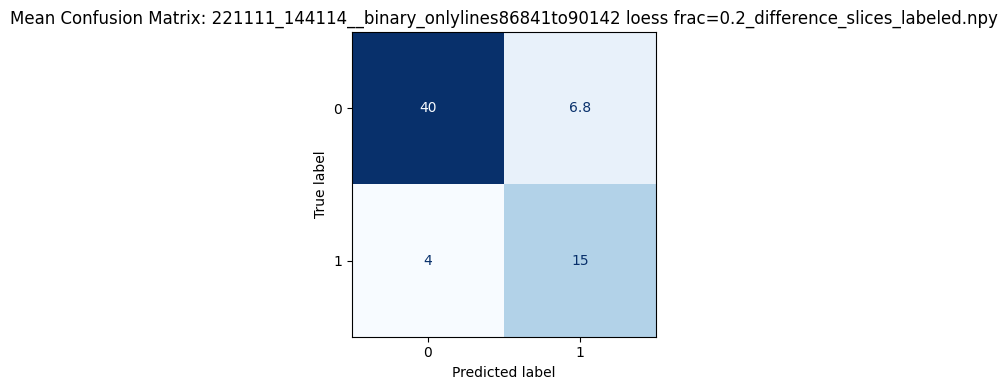

In [7]:
# Show confusion matrix for each file (mean over folds)
from sklearn.metrics import ConfusionMatrixDisplay

for file in df["file"].unique():
    cms = [np.array(row) for row in df[df["file"] == file]["confusion_matrix"]]
    # Find the largest shape
    max_dim = max(cm.shape[0] for cm in cms)
    # Pad all confusion matrices to max_dim x max_dim
    padded = []
    for cm in cms:
        pad_width = ((0, max_dim - cm.shape[0]), (0, max_dim - cm.shape[1]))
        padded.append(np.pad(cm, pad_width, mode='constant'))
    mean_cm = np.mean(padded, axis=0)
    display_labels = [str(l) for l in range(max_dim)]
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(mean_cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(f"Mean Confusion Matrix: {file}")
    plt.tight_layout()
    plt.show()